In [1]:
import os
import numpy as np
import pandas as pd

from pyInfinityFlow.InfinityFlow_Utilities import read_fcs_into_anndata
from pyInfinityFlow.InfinityFlow_Utilities import apply_logicle_to_anndata
from pyInfinityFlow.InfinityFlow_Utilities import pearson_corr_df_to_df
from pyInfinityFlow.InfinityFlow_Utilities import anndata_to_df
from pyInfinityFlow.fcs_io import FCSFileObject
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors

os.chdir("/media/kyle_storage/kyle_ferchen/grimes_lab_main/analysis/2022_12_07_new_multilin_panel/")

In [2]:
# Helper functions
def map_min_max(input_array, input_min, input_max):
    tmp_scaler = 1 / (input_max - input_min)
    input_array = np.array(input_array)
    input_array[input_array < input_min] = input_min
    input_array[input_array > input_max] = input_max
    return(tmp_scaler * (np.array(input_array) - input_min))

In [3]:
# Read in the annotation file
umap_anno = pd.read_csv("output/automated_py3_cellharmony_r7/"\
    "evenly_sampled_r7/umap_2d_coordinates_redo.csv", index_col=0)

umap_anno

,umap-x,umap-y
cell_id,,
:0,10.952296,-6.878245
:1,10.202045,7.717799
:2,12.240065,-3.202506
:3,6.748181,21.352978
:4,9.314702,5.906703
...,...,...
:1935032,-4.400203,-1.029844
:1935033,12.978972,-5.007983
:1935034,10.876128,5.335987


In [4]:
# Read in evenly sampled cells for background
even_sampled_cells = pd.read_csv("/media/kyle_storage/kyle_ferchen/"\
    "grimes_lab_main/analysis/2022_12_07_new_multilin_panel/output/"\
    "automated_py3_cellharmony_r7/evenly_sampled_r7/"\
    "list_evenly_sampled_cells_redo.csv", header=None).iloc[:,0]

even_sampled_cells

0           :1530
1           :3945
2           :8052
3           :8120
4          :10035
           ...   
99995    :1813998
99996     :838366
99997     :344154
99998     :836533
99999       :7039
Name: 0, Length: 100000, dtype: object

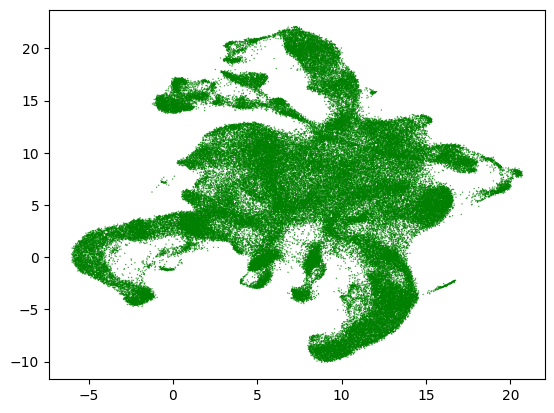

In [5]:
plt.scatter(\
    umap_anno.loc[even_sampled_cells.values, "umap-x"],
    umap_anno.loc[even_sampled_cells.values, "umap-y"],
    color="green",
    alpha=0.75,
    s=1,
    edgecolors="none")

In [6]:
# Read in the mapped ADT values
cite_mapped = pd.read_feather(\
    "output/cite_inflow_integration_input/"\
    "mapped_adt_different_normalizations/"\
    "mapped_cite_seq_adt_from_magic_log2.feather").set_index("index")

# ADT/RNA links files
path_cite_input = "output/cite_inflow_integration_input/"
links_adt = pd.read_csv(os.path.join(path_cite_input, "links_adt.csv"))
links_adt.index = ["ADT_Link-" + str(i) + ":" + \
    links_adt.loc[i, "OPTI_ADT"] + ":" + \
    links_adt.loc[i, "Channel"] for i in links_adt.index.values]


# Fix column names on reference data
cite_mapped.columns = links_adt.index.values

ref_groups = pd.read_csv("output/cite_inflow_integration_input/"\
    "without_adt_umi_filtering/cell_anno_cite_r7_all_cells.csv")
ref_groups.index = ref_groups["cell"]

cite_shared_cells = np.intersect1d(\
    ref_groups.index.values,
    cite_mapped.index.values)

cite_mapped

,ADT_Link-0:CCR3_CD193:CD193,ADT_Link-1:CD102:CD102,ADT_Link-2:CD105:BUV805-A,ADT_Link-3:CD106:PerCP-Cy5.5-A,ADT_Link-4:CD107a_LAMP_1:CD107a,ADT_Link-5:CD117_c_kit:BV650-A,ADT_Link-6:CD11a:CD11a,ADT_Link-7:CD11c:CD11c,ADT_Link-8:CD127:BV785-A,ADT_Link-9:CD135:PE-Cy5-A,...,ADT_Link-83:anti_human_mouse_CD49f:CD49f,ADT_Link-84:anti_human_mouse_integrin_7:BUV615-A,ADT_Link-85:anti_mouse_human_CD11b:BV750-A,ADT_Link-86:anti_mouse_human_CD44:CD44,ADT_Link-87:anti_mouse_rat_CD29:CD29,ADT_Link-88:anti_mouse_rat_CD61:CD61,ADT_Link-89:anti_mouse_rat_CD81:CD81,ADT_Link-90:anti_mouse_rat_human_CD27:BUV737-A,ADT_Link-91:CD49d:LPAM1,ADT_Link-92:anti_human_mouse_integrin_7:LPAM1
index,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGACCCTTA-1.AS_3CITE_Kitx2,0.350066,0.658259,0.297554,0.448768,0.445561,0.724472,0.681179,0.228199,0.219482,0.197334,...,0.656718,0.253717,0.141151,0.569371,0.760579,0.235294,0.706305,0.648623,0.281412,0.398380
AAACCCAAGACTCCGC-1.AS_3CITE_Kitx2,0.415502,0.368381,0.300510,0.438579,0.576833,0.592678,0.460838,0.231337,0.786378,0.225924,...,0.314293,0.141823,0.104177,0.404265,0.477928,0.299560,0.616417,0.214682,0.138649,0.248847
AAACCCAAGATAGCTA-1.AS_CITE_Kit,0.267738,0.362790,0.167813,0.415008,0.421252,0.328938,0.553126,0.224101,0.278638,0.178499,...,0.503286,0.104246,0.131233,0.713292,0.632402,0.526599,0.259022,0.393098,0.120904,0.126636
AAACCCAAGATGATTG-1.AS_CITE_Kit,0.740697,0.306850,0.826648,0.563585,0.777544,0.652055,0.748089,0.232210,0.539566,0.836301,...,0.502649,0.210033,0.651194,0.805416,0.545655,0.706222,0.676698,0.423907,0.263465,0.361955
AAACCCAAGGATTTGA-1.AS_CITE_Kit,0.255794,0.113841,0.581968,0.421379,0.366239,0.206559,0.148490,0.223417,0.363427,0.193719,...,0.180128,0.093796,0.103072,0.566656,0.605872,0.101947,0.639263,0.228029,0.200172,0.100597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGTCAAGGTGG-1.AS_CITE_CD127,0.293584,0.407147,0.202507,0.428243,0.451079,0.312129,0.675552,0.223516,0.298478,0.172611,...,0.700273,0.107453,0.093839,0.773396,0.806619,0.555756,0.358449,0.436244,0.178913,0.135606
TTTGTTGTCCAACTGA-1.AS_CITE_CD127,0.349906,0.355646,0.238143,0.434871,0.270631,0.294261,0.662443,0.227703,0.616251,0.215962,...,0.492915,0.245634,0.057038,0.791720,0.568679,0.431534,0.480974,0.774505,0.229917,0.392081
TTTGTTGTCCTTTGAT-1.AS_CITE_CD127,0.174761,0.532083,0.163280,0.403890,0.430589,0.571611,0.552725,0.224716,0.491324,0.174285,...,0.736057,0.128924,0.093807,0.777575,0.839777,0.574526,0.500919,0.674510,0.234357,0.203932


In [7]:
len(cite_shared_cells)

55403

In [8]:
ref_groups

,cell,umi_adt,port,cluster,ari_group
cell,,,,,
TTGTTTGTCCGTGGTG-1.AS_CITE_HSC,TTGTTTGTCCGTGGTG-1.AS_CITE_HSC,508,AS_CITE_HSC,LT-HSC_Mllt3,HSCP
TTTGGTTTCGCCTATC-1.AS_CITE_HSC,TTTGGTTTCGCCTATC-1.AS_CITE_HSC,512,AS_CITE_HSC,LT-HSC_Mllt3,NaN
GAGTTTGGTGCTGATT-1.AS_CITE_HSC,GAGTTTGGTGCTGATT-1.AS_CITE_HSC,548,AS_CITE_HSC,LT-HSC_Mllt3,NaN
GCTACAAGTTAGAAAC-1.AS_CITE_HSC,GCTACAAGTTAGAAAC-1.AS_CITE_HSC,548,AS_CITE_HSC,LT-HSC_Mllt3,HSCP
TTACCGCGTATGCAAA-1.AS_CITE_HSC,TTACCGCGTATGCAAA-1.AS_CITE_HSC,585,AS_CITE_HSC,LT-HSC_Mllt3,HSCP
...,...,...,...,...,...
TTGCGTCCAGTTAAAG-1.AS_CITE_HSC,TTGCGTCCAGTTAAAG-1.AS_CITE_HSC,1937,AS_CITE_HSC,HSC-Mac_Fcna,NaN
AATGAAGGTTGCCGCA-1.AS_CITE_HSC,AATGAAGGTTGCCGCA-1.AS_CITE_HSC,1972,AS_CITE_HSC,HSC-Mac_Fcna,NaN
AAGACTCGTAATCAGA-1.AS_CITE_HSC,AAGACTCGTAATCAGA-1.AS_CITE_HSC,1973,AS_CITE_HSC,HSC-Mac_Fcna,NaN


In [9]:
### Read in the InfinityFlow data
# Thresholds for scaling
min_max_thresh = pd.read_csv("output/cite_inflow_integration_input/"\
    "inflow_rescaling_thresholds.csv", index_col=0).T

min_max_thresh.columns = ["min", "max"]
min_max_thresh.head()

# Note the mapping of old infinityflow to new panel was redone, but the transfer
# to cite-seq distributions currently uses the old mapping
tmp_fcs = read_fcs_into_anndata("output/infinity_flow/infinity_flow_reprediction_on_new_panal_logicle_redo.fcs")

print("Applying logicle normalization...")
apply_logicle_to_anndata(tmp_fcs)

print("Rescaling features to remove outliers...")
rescaled = {}
for tmp_channel in min_max_thresh.index.values:
    input_array = tmp_fcs[:,tmp_channel].X.toarray().reshape(-1)
    rescaled[tmp_channel] = map_min_max(\
        input_array,
        min_max_thresh.loc[tmp_channel, "min"],
        min_max_thresh.loc[tmp_channel, "max"])
    
rescaled = pd.DataFrame(rescaled)

inflow_data = pd.DataFrame(\
    rescaled[links_adt["Channel"].values].values,
    columns=links_adt.index,
    index=tmp_fcs.obs.index.values)

del tmp_fcs
gc.collect()

# Fix na values in fcs data
print("Remove indices with NaN values:\n")
print(inflow_data.loc[inflow_data.isna().sum(axis=1) > 0].index.values)
inflow_data = inflow_data.loc[~(inflow_data.isna().sum(axis=1) > 0)]

# DataFrames for anndata objects
var_df = pd.DataFrame(\
    {"name": inflow_data.columns.values}, 
    index=inflow_data.columns.values)

Applying logicle normalization...
Rescaling features to remove outliers...
Remove indices with NaN values:

[]


In [10]:
# Define sampled infinityflow data
sampled_inflow = inflow_data.loc[even_sampled_cells,:].copy()
sampled_inflow.shape

(100000, 93)

<AxesSubplot: ylabel='Density'>

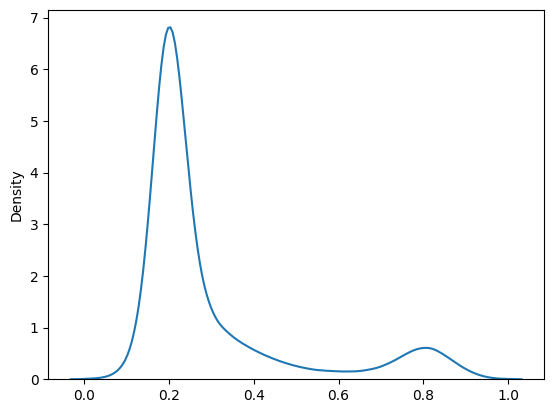

In [11]:
sns.kdeplot(inflow_data["ADT_Link-2:CD105:BUV805-A"].values)

In [12]:
# Find mapped cite seq cells nearest neighbors to even sampled infinityflow
# ~2 minutes runtime
inflow_knn_model = NearestNeighbors(n_neighbors=4, n_jobs=10)
inflow_knn_model.fit(sampled_inflow)
cite_nns_to_inflow = inflow_knn_model.kneighbors(\
    cite_mapped[sampled_inflow.columns.values])


In [22]:
map_cite_to_nn_anno = pd.DataFrame({\
    "nn_indices": ["|".join(\
        sampled_inflow.index.values[cite_nns_to_inflow[1][i]]) for i in \
            range(cite_nns_to_inflow[1].shape[0])]},
    index=cite_mapped.index.values)

map_cite_to_nn_anno.to_csv("output/automated_py3_cellharmony_r7/"\
    "evenly_sampled_r7/mapped_cite_into_inflow_umap/"\
    "mapped_cite_4nn_inflow_indices_annotation.csv",
    header=True, index=True, index_label="cell_id")


In [35]:
sampled_umap = umap_anno.loc[\
    even_sampled_cells.values, 
    ["umap-x", "umap-y"]]

In [62]:
nn_umap_pos = [sampled_umap.iloc[cite_nns_to_inflow[1][i],:] for i in \
            range(cite_nns_to_inflow[1].shape[0])]


In [63]:
mapped_pos = [np.mean(i, axis=0) for i in nn_umap_pos]

In [64]:
mapped_dists = [np.sqrt(np.sum(np.sum((i-j)**2))) for i,j in \
    zip(nn_umap_pos, mapped_pos)]

In [65]:
mapping_stats = pd.concat(mapped_pos, axis=1).T
mapping_stats["distance"] = mapped_dists
mapping_stats.index = cite_mapped.index.values
mapping_stats

,umap-x,umap-y,distance
AAACCCAAGACCCTTA-1.AS_3CITE_Kitx2,5.345636,2.932951,1.307306
AAACCCAAGACTCCGC-1.AS_3CITE_Kitx2,8.673631,18.472217,1.329562
AAACCCAAGATAGCTA-1.AS_CITE_Kit,13.759725,4.994706,1.895104
AAACCCAAGATGATTG-1.AS_CITE_Kit,10.333968,-5.424311,1.969685
AAACCCAAGGATTTGA-1.AS_CITE_Kit,-3.412491,-2.073433,3.071695
...,...,...,...
TTTGTTGTCAAGGTGG-1.AS_CITE_CD127,14.337215,4.641710,1.052339
TTTGTTGTCCAACTGA-1.AS_CITE_CD127,10.777680,14.459398,4.195975
TTTGTTGTCCTTTGAT-1.AS_CITE_CD127,11.747635,6.838523,1.274682
TTTGTTGTCTTCGTGC-1.AS_CITE_HSC,2.921753,9.047178,1.068364


In [76]:
# Save the mapped CITE-seq cells
mapping_stats.to_csv("output/automated_py3_cellharmony_r7/evenly_sampled_r7/"\
    "mapped_cite_into_inflow_umap/mapped_cite_4nn_umap_and_dist_annotation.csv",
    header=True, index=True, index_label="cell")

In [68]:
ref_groups["port"].value_counts()

AS_CITE_Kit          9357
AS_3CITE_Kitx2       9051
AS_3CITE_Kit         8634
AS_CITE_CD127        8275
AS_CITE_HSC          8034
AS_CITE_Multilin1    7609
AS_CITE_Multilin2    4443
Name: port, dtype: int64

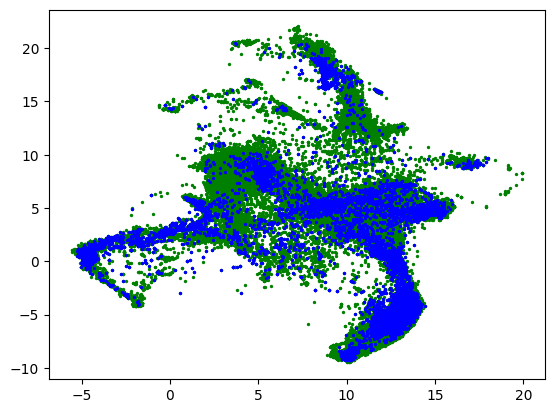

In [75]:
plt.scatter(\
    mapping_stats["umap-x"].values,
    mapping_stats["umap-y"].values,
    color="green",
    s=2,)


# subcells_to_plot = np.intersect1d(\
#     ref_groups.loc[ref_groups["cluster"] == "Eosinophils"].index.values,
#     mapping_stats.index.values)

subcells_to_plot = np.intersect1d(\
    ref_groups.loc[ref_groups["port"] == "AS_3CITE_Kitx2"].index.values,
    mapping_stats.index.values)

plt.scatter(\
    mapping_stats.loc[subcells_to_plot, "umap-x"].values,
    mapping_stats.loc[subcells_to_plot, "umap-y"].values,
    color="blue",
    s=2,)

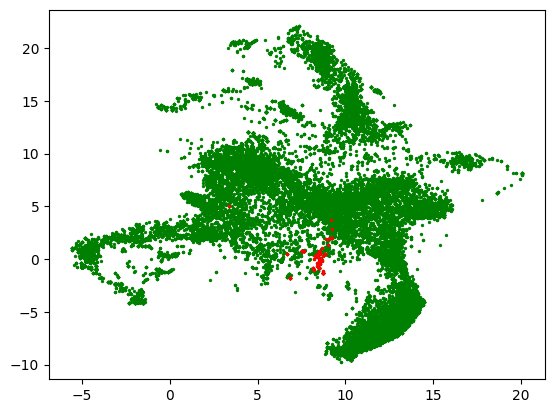

In [61]:
plt.scatter(\
    mapping_stats["umap-x"].values,
    mapping_stats["umap-y"].values,
    color="green",
    s=2,)


# subcells_to_plot = np.intersect1d(\
#     ref_groups.loc[ref_groups["cluster"] == "Eosinophils"].index.values,
#     mapping_stats.index.values)
plt.scatter(\
    mapping_stats.loc[subcells_to_plot, "umap-x"].values,
    mapping_stats.loc[subcells_to_plot, "umap-y"].values,
    color="red",
    s=2,)

(-4.0, 10.0)

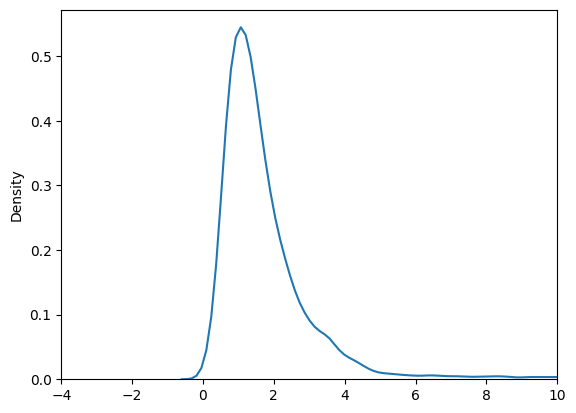

In [47]:
sns.kdeplot(mapped_dists)
plt.xlim((-4,10))

In [ ]:
ll_mapped_cite_rename_features = all_mapped_cite.rename(feature_to_inflow_name.to_dict(), axis=1).copy()
shared_inflow_feature_names = np.intersect1d(all_mapped_cite_rename_features.columns.values, rescaled.columns.values)
# inflow_knn_model = NearestNeighbors(n_neighbors=5, n_jobs=10)
# inflow_knn_model.fit(rescaled.iloc[:,:][shared_inflow_feature_names])
# # cite_nns_to_inflow = inflow_knn_model.kneighbors(rescaled[shared_inflow_feature_names])
# # 2.7 hours for 61,544 cells mapping to nearest neighbors from 5,752,004 cells
# start_time = time.time()
# cite_nns = inflow_knn_model.kneighbors(all_mapped_cite_rename_features[shared_inflow_feature_names])
# end_time = time.time()


# with open("output/python_objects/inflow_5_knn_model_for_cite_embedding_2022_07_06.pickle", "wb") as tmp_file:
#     pickle.dump(inflow_knn_model, tmp_file)

with open("output/python_objects/inflow_5_knn_model_for_cite_embedding_2022_07_06.pickle", "rb") as tmp_file:
    inflow_knn_model = pickle.load(tmp_file)

# with open("output/python_objects/cite_knns_to_inflow_2022_07_06.pickle", "wb") as tmp_file:
#     pickle.dump(cite_nns, tmp_file)

with open("output/python_objects/cite_knns_to_inflow_2022_07_06.pickle", "rb") as tmp_file:
    cite_nns = pickle.load(tmp_file)



cite_nn_embedding = []
cite_nn_embedding_distances_from_center = []
for i in range(cite_nns[1].shape[0]):
    tmp_center = np.mean(embedding_scaled[cite_nns[1][i],:], axis=0)
    cite_nn_embedding_distances_from_center.append(np.sqrt(np.sum((embedding_scaled[cite_nns[1][i],:]-tmp_center)**2)))
    cite_nn_embedding.append(list(tmp_center))

cite_nn_embedding = np.array(cite_nn_embedding)
cite_nn_embedding_distances_from_center = np.array(cite_nn_embedding_distances_from_center)
sel_cite_nn_embedding_indices = np.where(cite_nn_embedding_distances_from_center < 4)



# Save inflow nearest neighbors as a new sample for projection
inflow_near_cite = np.array(sorted(np.unique(cite_nns[1].flatten())))

In [31]:
r_df = pearson_corr_df_to_df(ref_data.head(1000).T, inflow_data.T)


: 

: 

In [30]:
len(r_df.idxmax(axis=1).unique())

91

In [11]:
adt_centroids = ref_data.loc[cite_shared_cells,:]
adt_centroids["cluster"] = ref_groups.loc[\
    adt_centroids.index.values, 
    "cluster"].values
adt_centroids = pd.pivot_table(adt_centroids, index="cluster", aggfunc=np.mean)
adt_centroids

,ADT_Link-0:CCR3_CD193:CD193,ADT_Link-10:CD14:CD14,ADT_Link-11:CD140a:CD140a,ADT_Link-12:CD150_SLAM:BV711-A,ADT_Link-13:CD155_PVR:CD155,ADT_Link-14:CD159a_NKG2AB6:CD159a,ADT_Link-15:CD163:CD163,ADT_Link-16:CD169_Siglec_1:CD169,ADT_Link-17:CD16_32:BUV395-A,ADT_Link-18:CD170_Siglec_F:CD170,...,ADT_Link-85:anti_mouse_human_CD11b:BV750-A,ADT_Link-86:anti_mouse_human_CD44:CD44,ADT_Link-87:anti_mouse_rat_CD29:CD29,ADT_Link-88:anti_mouse_rat_CD61:CD61,ADT_Link-89:anti_mouse_rat_CD81:CD81,ADT_Link-8:CD127:BV785-A,ADT_Link-90:anti_mouse_rat_human_CD27:BUV737-A,ADT_Link-91:CD49d:LPAM1,ADT_Link-92:anti_human_mouse_integrin_7:LPAM1,ADT_Link-9:CD135:PE-Cy5-A
cluster,,,,,,,,,,,,,,,,,,,,,
B-cell progenitor,0.324191,0.203532,0.159239,0.351365,0.933528,0.318346,0.099372,0.210709,0.060886,0.138331,...,0.020739,0.642777,0.476378,0.174312,0.605791,0.707305,0.611535,0.128429,0.155474,0.296966
BMCP,0.339864,0.227857,0.187783,0.398569,0.789254,0.354564,0.199733,0.807377,0.396559,0.805430,...,0.174666,0.599896,0.732730,0.363552,0.755687,0.483181,0.643131,0.339721,0.420640,0.194258
Baso,0.339531,0.212867,0.180889,0.398808,0.864920,0.341858,0.187674,0.772757,0.559210,0.694638,...,0.210476,0.526597,0.668746,0.225502,0.760856,0.436235,0.416669,0.315058,0.524106,0.193250
Bcl11b+_preETP_Cd3d,0.376795,0.272973,0.179595,0.387332,0.388933,0.331581,0.113872,0.263076,0.118301,0.181721,...,0.053981,0.246933,0.275626,0.583256,0.174171,0.562134,0.599383,0.198250,0.564630,0.208149
Bcl11b+_preETP_Tdrd5,0.334122,0.221154,0.166348,0.340177,0.305574,0.392960,0.113432,0.242056,0.068770,0.160100,...,0.045769,0.611224,0.567410,0.487371,0.404118,0.709169,0.696002,0.431290,0.554795,0.198992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
preNeu-3-Mac_C1qa,0.423518,0.230109,0.160682,0.368523,0.404568,0.309952,0.197904,0.425018,0.439875,0.192135,...,0.661041,0.784437,0.572062,0.644366,0.715677,0.364335,0.311411,0.173129,0.154852,0.232398
preNeu-Ebf1,0.320963,0.200194,0.146244,0.369919,0.532104,0.324099,0.188661,0.548027,0.416376,0.259147,...,0.637043,0.827296,0.728185,0.656545,0.787841,0.456140,0.455292,0.235742,0.184671,0.188392
proNeu-1,0.243159,0.176740,0.169901,0.378808,0.842748,0.400353,0.126763,0.263731,0.260110,0.744447,...,0.247156,0.822768,0.851607,0.524259,0.692571,0.438553,0.633557,0.476356,0.177434,0.167650


In [22]:
print(adt_centroids["ADT_Link-45:CD371_CLEC12A:APC-A"].sort_values(ascending=False).to_string())

cluster
Eosinophils              0.611129
proNeu-1                 0.545502
IG2-proNeu1              0.512126
MultiLin-2_F13a1         0.505343
MDP-Irf8                 0.501510
MDP-Cpa3                 0.495667
CD127-MP                 0.469264
ML-cell-cycle            0.462960
Ebf1+ proB_Hmga2         0.460288
proNeu-1-ADT             0.453952
preNeu-Ebf1              0.445762
IG2-MP                   0.444285
ST-HSC-CC-Mac-2          0.434175
MultiLin-2_Ms4a3         0.430599
cMoP-Mki67               0.426026
proNeu-2                 0.420506
preNeu-3-Mac_C1qa        0.418756
Baso                     0.411408
cMoP-S100a4              0.410639
preNeu-1                 0.409210
preNeu-3-ADT             0.408344
DN4-DP-trans_Hist1h3c    0.406176
pre-cDC1_Egfl8           0.405025
ST-HSC-CC-Mac-1          0.404124
CLP1-Rrm2                0.403107
pre-cDC2                 0.387329
CD127-BMCP               0.385677
pre-cDC1_Xcr1            0.384688
immNeu-1                 0.377204
MultiL

In [20]:
print("\n".join(adt_centroids.columns.values))

ADT_Link-0:CCR3_CD193:CD193
ADT_Link-10:CD14:CD14
ADT_Link-11:CD140a:CD140a
ADT_Link-12:CD150_SLAM:BV711-A
ADT_Link-13:CD155_PVR:CD155
ADT_Link-14:CD159a_NKG2AB6:CD159a
ADT_Link-15:CD163:CD163
ADT_Link-16:CD169_Siglec_1:CD169
ADT_Link-17:CD16_32:BUV395-A
ADT_Link-18:CD170_Siglec_F:CD170
ADT_Link-19:CD172a_SIRP:CD172a
ADT_Link-1:CD102:CD102
ADT_Link-20:CD182_CXCR2:CD182
ADT_Link-21:CD183_CXCR3:CD183
ADT_Link-22:CD1d_CD1_1_Ly_38:CD1d
ADT_Link-23:CD2:CD2
ADT_Link-24:CD20:CD20
ADT_Link-25:CD200R_OX2R:CD200r
ADT_Link-26:CD200_OX2:CD200
ADT_Link-27:CD201_EPCR:PerCP-eFluor710-A
ADT_Link-28:CD205_DEC_205:CD205
ADT_Link-29:CD21_CD35_CR2_CR1:CD21_35
ADT_Link-2:CD105:BUV805-A
ADT_Link-30:CD22:CD22
ADT_Link-31:CD223_LAG_3:CD223
ADT_Link-32:CD23:CD23
ADT_Link-33:CD24:CD24
ADT_Link-34:CD25:CD25
ADT_Link-35:CD26_DPP_4:CD26
ADT_Link-36:CD270_HVEM:CD270
ADT_Link-37:CD274_B7_H1_PD_L1:CD274
ADT_Link-38:CD279_PD_1:CD279
ADT_Link-39:CD300LG_Nepmucin:CD300LG
ADT_Link-3:CD106:PerCP-Cy5.5-A
ADT_Link-40:CD301b